# Imports & Settings

In [1]:
import json
import numpy as np
import pandas as pd
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# CIKs for S&P 500 Constituents

In [2]:
df = pd.read_csv('data/sp500_ciks.csv', dtype=str)
df.head()

,Symbol,Security,SEC filings,GICS Sector,GICS Sub-Industry,Headquarters Location,Date first added,CIK,Founded
0,MMM,3M,reports,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1976-08-09,0000066740,1902
1,ABT,Abbott Laboratories,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,0000001800,1888
2,ABBV,AbbVie,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,0001551152,2013 (1888)
3,ABMD,Abiomed,reports,Health Care,Health Care Equipment,"Danvers, Massachusetts",2018-05-31,0000815094,1981
4,ACN,Accenture,reports,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,0001467373,1989


In [3]:
df.shape

(505, 9)

# Plotting a Concept for a Given Company

In [4]:
def get_company_cik(ticker):
    return df.loc[df.Symbol == ticker, 'CIK'].values[0]

In [5]:
def get_company_facts(ticker):
    cik = get_company_cik(ticker)
    with open(f'data/sec_bulk_data/CIK{cik}.json') as f:
        facts = json.load(f)
    return facts

In [6]:
def get_company_concepts(ticker):
    facts = get_company_facts(ticker)
    return facts['facts']['us-gaap'].keys()

In [7]:
def get_concept_description(ticker, concept, label=False):
    facts = get_company_facts(ticker)
    concept = facts['facts']['us-gaap'][concept]
    try:
        if label:
            return concept['label'], concept['description']
        return concept['description']
    except KeyError as e:
        print(f'KeyError: The specified company does not have a concept of \'{concept}\'')

In [123]:
def get_concept_values(ticker, concept, frame_only=True, frame_filter='Q', as_df=False):
    facts = get_company_facts(ticker)
    concept_values = facts['facts']['us-gaap'][concept]['units']['USD']
    
    if frame_only:
        concept_values = [item for item in concept_values if 'frame' in item.keys()]
        concept_values = [item for item in concept_values if frame_filter in item['frame']]
    
    if as_df:
        df = pd.DataFrame(data={concept: [item['val'] for item in concept_values]},
                          index=[pd.to_datetime(item['end']) for item in concept_values])
        df.sort_index(ascending=True, inplace=True)
        return df
    
    return concept_values

In [9]:
def plot_concept(ticker, concept):
    # Storing the data in a dataframe for easier plotting
    concept_values = get_concept_values(ticker, concept)
    df = pd.DataFrame({'Date': [pd.to_datetime(item['end']) for item in concept_values],
                       'Frame': [item['frame'] for item in concept_values],
                       concept: [item['val'] for item in concept_values]})
    
    # Changing format of the Frame column
    def frame_format(x):
        q = x[x.index('Q'):x.index('Q')+2]
        y = x[4:6]
        return f"{q}'{y}"
    df.Frame = df.Frame.apply(frame_format)
    
    # Plotting
    sns.barplot(data=df, x='Date', y=concept, color='#00b894')
    sns.despine()
    plt.title(f'{ticker} - {concept}', fontweight='bold')
    plt.xticks(ticks=np.arange(0, len(df), 4), labels=df.Frame[::4])

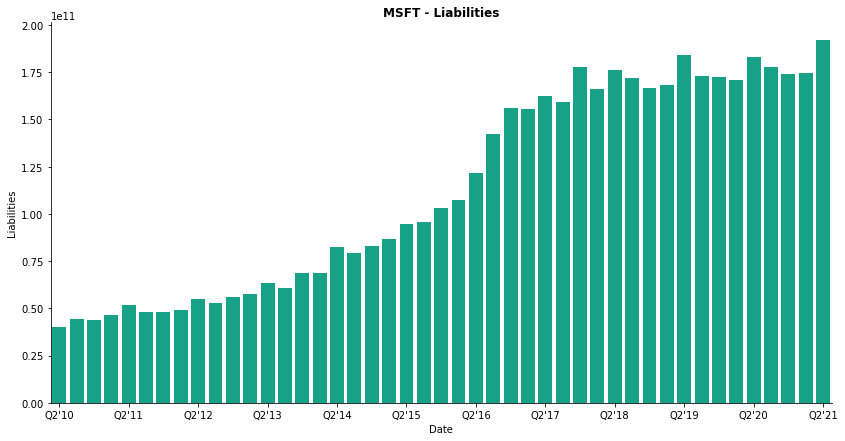

In [10]:
fig = plt.figure(figsize=(14, 7))
plot_concept('MSFT', 'Liabilities')

# Retrieving Price Histories
## Downloading Data

In [11]:
data = yf.download(tickers=df.Symbol.values.tolist(),
                   period='max',
                   group_by='ticker')

[*********************100%***********************]  505 of 505 completed

1 Failed download:
- BF.B: 1d data not available for startTime=-2208988800 and endTime=1629247883. Only 100 years worth of day granularity data are allowed to be fetched per request.


It appears that the ticker `BF.B` failed. The '.B' portion of the ticker refers to share class. Referencing the share class in a ticker is not fully standardized across different financial sources and can sometimes be represented as a hyphen instead of a period. I will try to download the data for `BF.B` by manually changing it to `BF-B` instead.

In [12]:
bfb = yf.download(tickers='BF-B', period='max')
bfb.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1980-03-17,0.0,0.447407,0.442963,0.442963,0.204822,202500
1980-03-18,0.0,0.442963,0.442963,0.442963,0.204822,84375
1980-03-19,0.0,0.448889,0.442963,0.448889,0.207562,329063
1980-03-20,0.0,0.450370,0.447407,0.450370,0.208247,354375
1980-03-21,0.0,0.450370,0.438519,0.444444,0.205507,2910938


In [13]:
data.shape

(15011, 3030)

In [14]:
data.columns

MultiIndex([('MRNA',      'Open'),
            ('MRNA',      'High'),
            ('MRNA',       'Low'),
            ('MRNA',     'Close'),
            ('MRNA', 'Adj Close'),
            ('MRNA',    'Volume'),
            ( 'VTR',      'Open'),
            ( 'VTR',      'High'),
            ( 'VTR',       'Low'),
            ( 'VTR',     'Close'),
            ...
            ( 'SYK',       'Low'),
            ( 'SYK',     'Close'),
            ( 'SYK', 'Adj Close'),
            ( 'SYK',    'Volume'),
            ('FITB',      'Open'),
            ('FITB',      'High'),
            ('FITB',       'Low'),
            ('FITB',     'Close'),
            ('FITB', 'Adj Close'),
            ('FITB',    'Volume')],
           length=3030)

## Exporting Individual Histories
The data returned by the `yfinance.download()` function placed everything into a single dataframe with columns grouped by ticker. While useful for quickly analyzing / plotting any of the companies' histories, there are two primary issues with having everything in one dataframe:
- The file is much larger than the 100MB limit imposed by GitHub. While solutions for handling large file uploads exist, it's preferable to avoid such workarounds unless absolutely needed.
- Thinking forward to the interactive dashboard portion of this project, loading in all of the price history data for every company in the S&P 500 whenever we want to analyze just one is a waste of resources and will likely lead to unwanted load times.

By splitting the data up into individual files, both of these issues are resolved. To start, I'll export the `BF.B` / `BF-B` dataframe and then move on to looping over all of the others.

In [15]:
bfb.to_csv('data/price_histories/BF-B_history.csv')
print('Successfully saved BF-B\'s history.')

Successfully saved BF-B's history.


In [16]:
tickers = df.Symbol.values.tolist()
for i, ticker in enumerate(tickers):
    if ticker == 'BF.B':
        continue
    df_temp = data[ticker].dropna()
    df_temp.to_csv(f'data/price_histories/{ticker}_history.csv')
    print(f'{i+1} / {len(tickers)} completed', end='\r')

# Exploring Concepts and Prices
The idea of regressing certain pieces of fundamental data for a given company against its share price is at the core of this project. The function below allows for plotting a quick scatterplot for a given company's share price and any one of its concepts listed in the output of calling `get_company_concepts()` with its ticker as an argument.

In [75]:
def plot_scatter(ticker, concept, adjusted_price=False):
    df_concept = get_concept_values(ticker, concept, as_df=True)
    df_price = pd.read_csv(f'data/price_histories/{ticker}_history.csv',
                           index_col='Date',
                           parse_dates=['Date'])
    
    target_col = 'Close' if not adjusted_price else 'Adj Close'
    df_price = df_price[[target_col]]
        
    df_merged = pd.merge_asof(left=df_concept,
                              right=df_price, 
                              left_index=True, 
                              right_index=True)
    
    sns.scatterplot(x=concept,
                    y=target_col,
                    data=df_merged)
    plt.title(f'{ticker} - {concept} vs {target_col}')

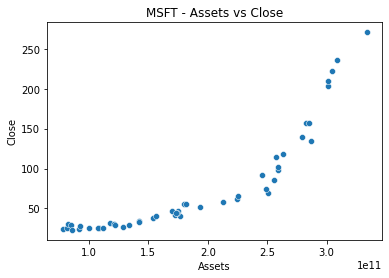

In [135]:
plot_scatter('MSFT', 'Assets')

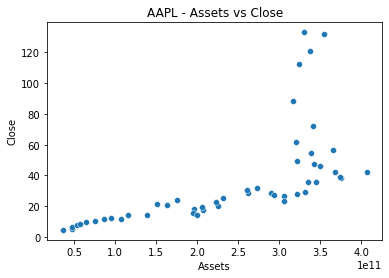

In [136]:
plot_scatter('AAPL', 'Assets')

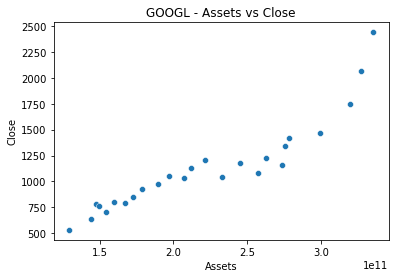

In [137]:
plot_scatter('GOOGL', 'Assets')